<a href="https://colab.research.google.com/github/vitamingyu/NLP-LLM/blob/main/tf_53dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# DCGAN : CNN을 GAN에 적용한 알고리즘
# MNIST dataset을 사용
# input -> Generator(생성자) -> fake data -> Descriminator가 판별 (원본과 구분할 수 없는 가짜 데이터가 생성될 때 까지 반복)
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ReLU, LeakyReLU, Conv2D, UpSampling2D
from keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [11]:
# Generator가 만드는 이미지 저장 폴더
if not os.path.exists('./gan_imgs'):
  os.makedirs('./gan_imgs')

# np.random.seed(3)
tf.random.set_seed(3)

# Generator model
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(alpha=0.2)))  # GAN은 ReLU 학습이 다소 불안정 하기에 LeakyReLU사용
generator.add(BatchNormalization())  # 데이터 정규화 - 안정적 학습 :과적합 방지 효과
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())  # 이미지 크기를 2배 확장
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.3)))  # alpha = 음의 기울기 계수  -1 ~ 1 사이
generator.add(UpSampling2D())  # 이미지 크기를 2배 확장
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

print(generator.summary())

# Discriminator model
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, padding='same', strides=2, input_shape=(28, 28, 1)))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Conv2D(128, kernel_size=5, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_14 (Ba  (None, 6272)              25088     
 tchNormalization)                                               
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_14 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_15 (Ba  (None, 14, 14, 64)      

In [12]:
# gan model
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(optimizer = 'adam', loss = 'binary_crossentropy')
print(gan.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_14 (Sequential)  (None, 28, 28, 1)         865281    
                                                                 
 sequential_15 (Sequential)  (None, 1)                 231681    
                                                                 
Total params: 1096962 (4.18 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 244353 (954.50 KB)
_________________________________________________________________
None


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 27ms/step
epoch:1508  d_loss=0.2355  g_loss=3.2964
1/1 [==============================] - 0s 26ms/step
epoch:1509  d_loss=0.3273  g_loss=2.3187
1/1 [==============================] - 0s 26ms/step
epoch:1510  d_loss=0.4353  g_loss=2.5743
1/1 [==============================] - 0s 29ms/step
epoch:1511  d_loss=0.3494  g_loss=2.1899
1/1 [==============================] - 0s 25ms/step
epoch:1512  d_loss=0.2301  g_loss=2.4442
1/1 [==============================] - 0s 32ms/step
epoch:1513  d_loss=0.2861  g_loss=2.6698
1/1 [==============================] - 0s 39ms/step
epoch:1514  d_loss=0.2779  g_loss=3.1060
1/1 [==============================] - 0s 25ms/step
epoch:1515  d_loss=0.3229  g_loss=2.9956
1/1 [==============================] - 0s 25ms/step
epoch:1516  d_loss=0.2806  g_loss=2.2938
1/1 [==============================] - 0s 25ms/step
epoch:1517  d_loss=0.4318  g_loss=2.1683
1/1 [=============================

<ipython-input-16-1856b485c53f>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 5)


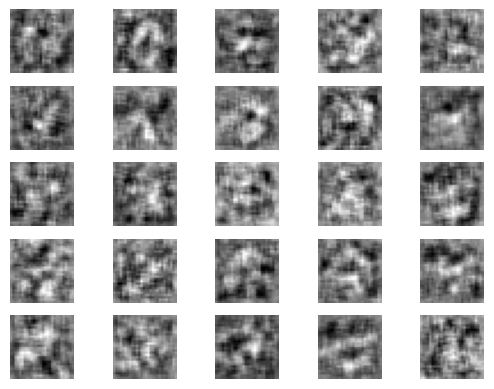

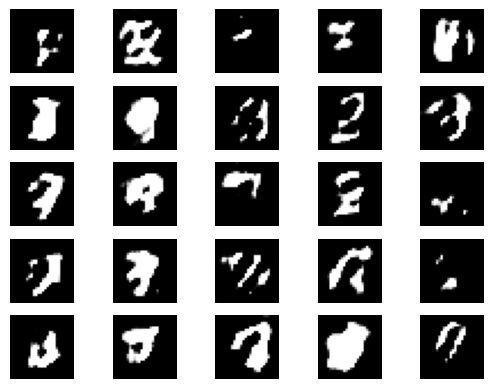

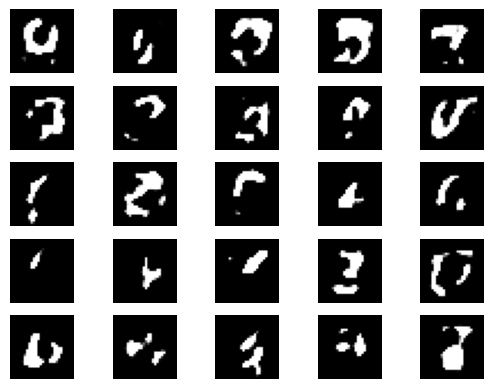

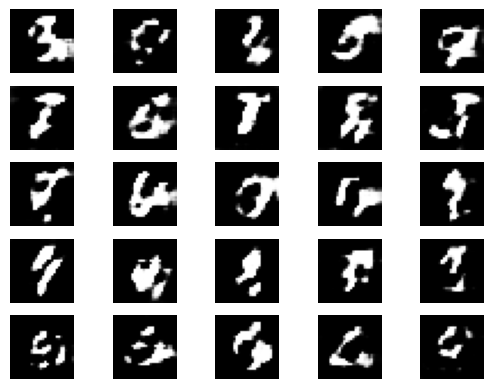

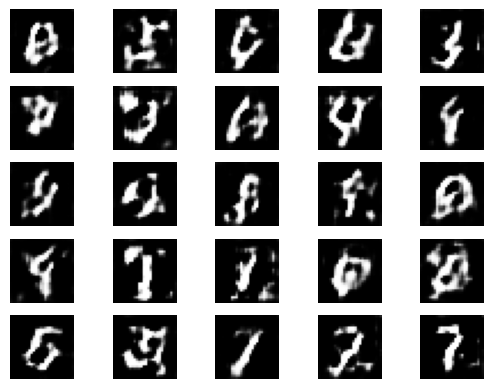

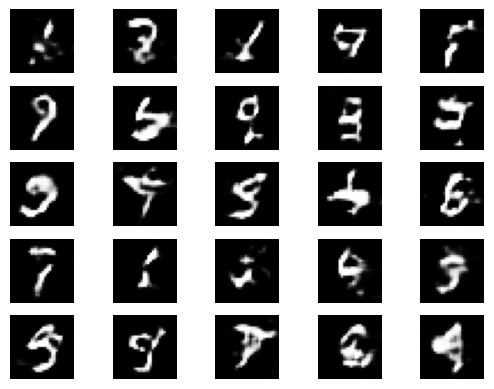

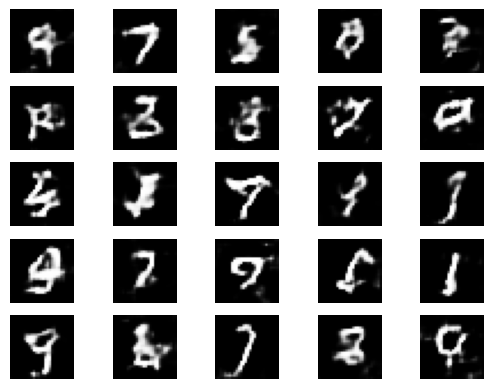

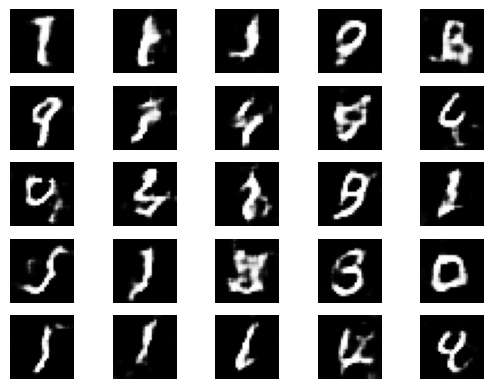

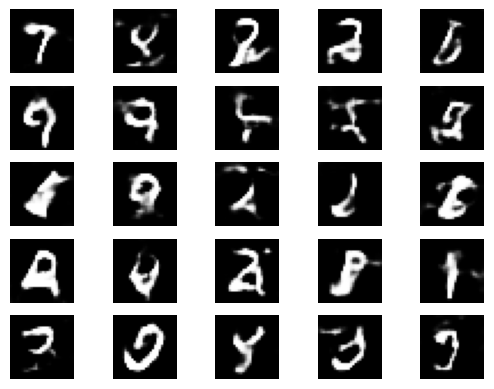

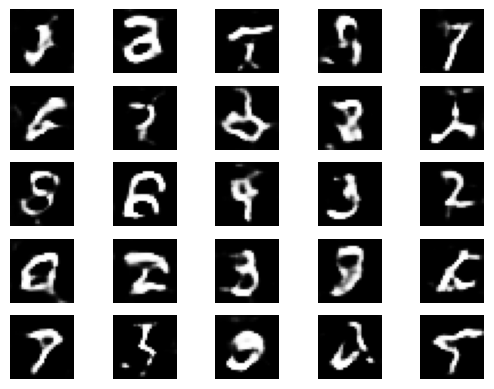

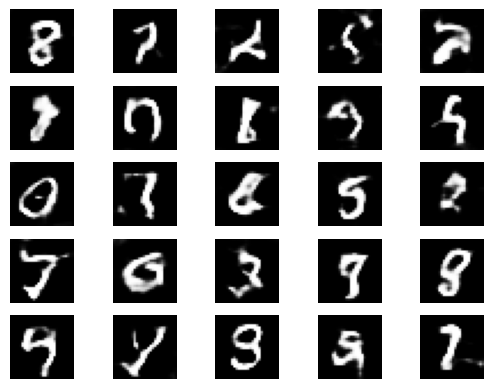

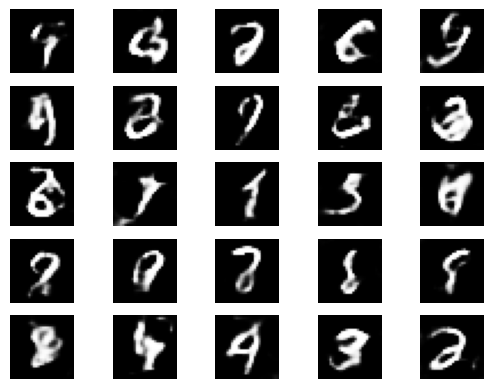

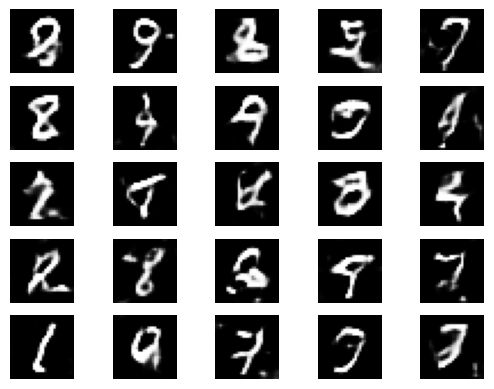

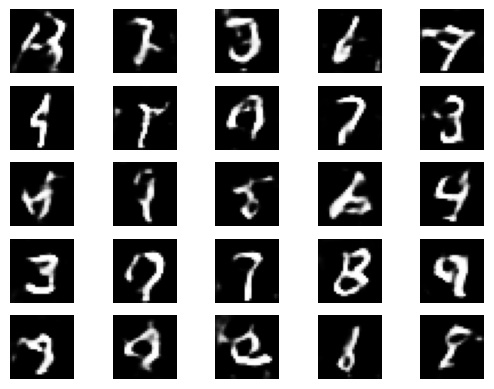

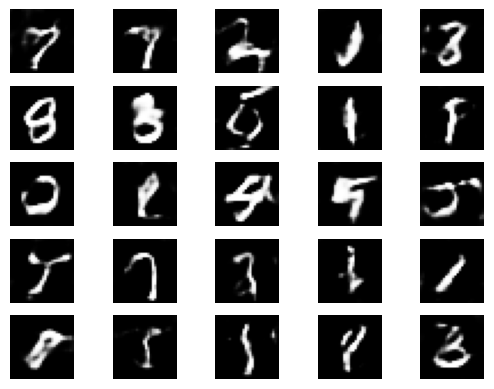

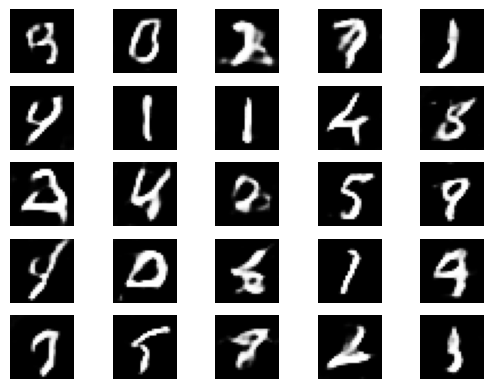

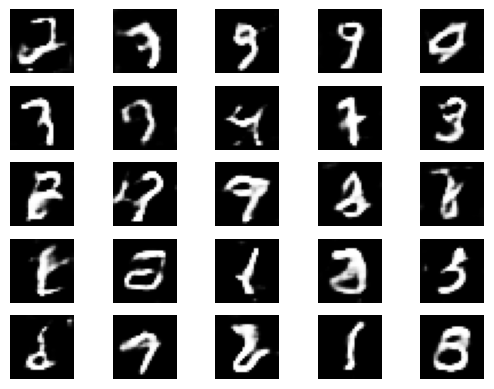

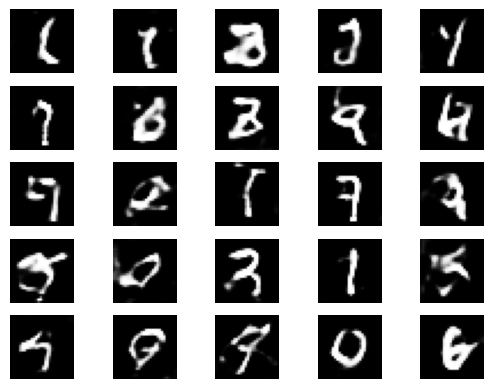

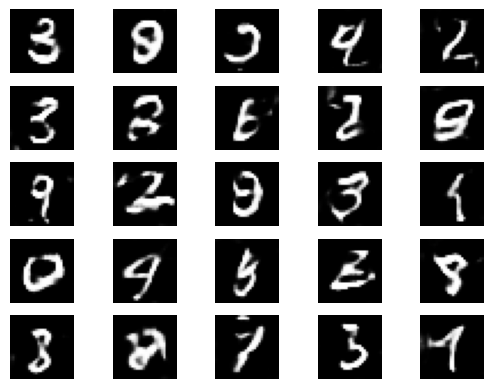

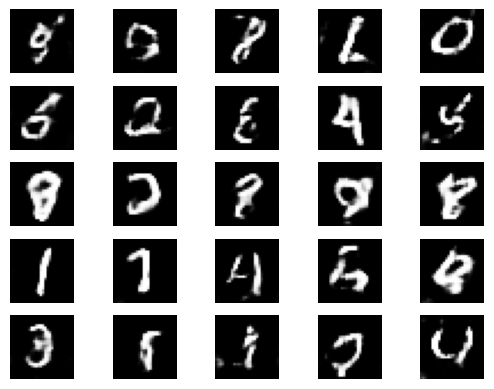

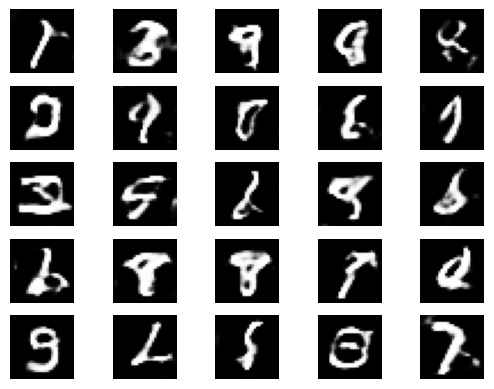

In [16]:
# 신경망 실행 함수
def gan_train(epoch, batch_size, saving_interval):
  (x_train, _),(x_test, _) = mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
  x_train = (x_train - 127.5) / 127.5  # -1 ~ 1사이 값으로 바뀜

  true = np.ones((batch_size, 1))
  # batch_size는 한 번에 몇개의 실제 이미지와 가짜이미지를 판별자에 넣을지 결정
  # 먼저 batch_size 만큼 mnist이미지를 랜덤하게 불러와 판별자에 집어 넣는 과정이다. 실제 이미지를 입력했으므로 모두 참(1)

  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, x_train.shape[0], batch_size)  # 실제 이미지를 랜덤하게 선택해 판별자에 입력
    imgs = x_train[idx]

    d_loss_real = discriminator.train_on_batch(imgs, true)  # batch_size만큼 판별시작

    # 가상 이미지를 판별자에 입력하기
    noise = np.random.normal(0,1,(batch_size, 100))  # 잠재공간에서 무작위로 샘플링
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)  # gen_imgs에 모두 가짜(0)라는 레이블이 붙음

    # 판별자와 생산자의 오차를 계산
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5
    g_loss = gan.train_on_batch(noise, true)  # 판별자와 생성자를 연결해서 만든 gan모델을 이용해 생성자의 오차(g_loss)를 구함
    print('epoch:%d'%i, ' d_loss=%.4f'%d_loss, ' g_loss=%.4f'%g_loss)  # 생성자와 파별자의 오차출력

    if i % saving_interval ==0:
      noise = np.random.normal(0,1,(25, 100))  # 잠재공간에서 무작위로 샘플링
      gen_imgs = generator.predict(noise)
      gen_imgs = gen_imgs * 0.5 + 0.5  # rescale : 0 ~ 1

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
      fig.savefig('gan_imgs/gmnist_%d.png'%i)

gan_train(4001, 32, 200)